In [1]:
#Tabular Playground Series - Jun 2021
#Link Below
#https://www.kaggle.com/competitions/tabular-playground-series-jun-2021

import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [23]:
random_state = 42
np.random.seed(random_state) # this sets the random sequence. Setting only this the repeatability is guaranteed
                             # only if we re-execute the entire notebook

# load train and test and show the shapes
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print(df_train.shape, df_test.shape)

(200000, 77) (100000, 76)


In [24]:
# show 10 random records
df_train.sample(10, random_state=random_state)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
119737,119737,0,0,15,0,0,0,0,0,11,...,0,0,1,0,0,0,1,0,0,Class_3
72272,72272,0,0,1,0,0,1,0,0,0,...,0,0,0,0,3,0,0,0,0,Class_6
158154,158154,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,Class_6
65426,65426,6,0,0,0,0,2,0,0,0,...,3,7,2,1,0,0,0,1,1,Class_8
30074,30074,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,Class_1
23677,23677,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,Class_2
134858,134858,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,1,0,0,0,Class_9
176418,176418,0,0,0,0,0,14,0,0,0,...,0,0,1,1,1,2,0,0,0,Class_2
132467,132467,0,2,1,3,1,0,0,7,8,...,0,1,0,0,20,18,1,0,1,Class_8
4082,4082,40,0,0,0,0,0,0,2,0,...,0,1,0,0,0,0,0,0,0,Class_5


In [25]:
# number of unique values
df_train.nunique().sort_values(ascending=False)

id            200000
feature_15       105
feature_60        99
feature_59        92
feature_73        91
               ...  
feature_18        21
feature_26        20
feature_30        18
feature_17        15
target             9
Length: 77, dtype: int64

In [26]:
# show target labels
target = "target"

labels = df_train[target].unique()
labels.sort()
labels

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [29]:
# create X_full
le = LabelEncoder()

X_full = df_train.drop(labels=["id", target], axis=1)
y = le.fit_transform(df_train[target])


In [30]:
# show X_full
X_full.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,0,0,6,1,0,0,0,0,7,0,...,3,0,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,3,0,0,...,8,0,0,0,0,1,0,0,0,0
3,0,0,7,0,1,5,2,2,0,1,...,0,0,4,0,2,2,0,4,3,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# during development use only a pair of usually fast models
model_lbls = ['dt' # decision tree
             #,'nb' # gaussian naive bayes
             ,'rf'   # random forest
             #,'lp'   # linear perceptron
             #,'svc'  # support vector
             #,'knn'  # k nearest neighbours
             #,'adb'  # adaboost
            ]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-12,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state),
           'param': [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],
                    },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[20,30,40,50]
                     ,'learning_rate':[0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{
                      # 'max_depth': [*range(4,30)]
                      'max_depth': [*range(4,30,4)]
                    #  ,'n_estimators':[*range(20,80,5)]
                     ,'n_estimators':[*range(10,30,5)]
                     ,'class_weight': [None,'balanced']
                      }]
          }

}


In [48]:
# Sort the explained variance ratios in descending order
pca = PCA()

X_transformed = pca.fit_transform(X_full)

# Calculate the cumulative sum of the explained variance ratios
cumulative_variances = np.cumsum(sorted(pca.explained_variance_ratio_, reverse=True))

# Find the index i of the first principal component where the cumulative sum exceeds 0.05
cutoff_variance = 0.8
cutoff_index = np.argmax(cumulative_variances > cutoff_variance)
print(f"Will use the top {cutoff_index} features")

# Keep the first i principal components and discard the rest
X = pca.transform(X_full)[:, :cutoff_index+1]

Will use the top 30 features


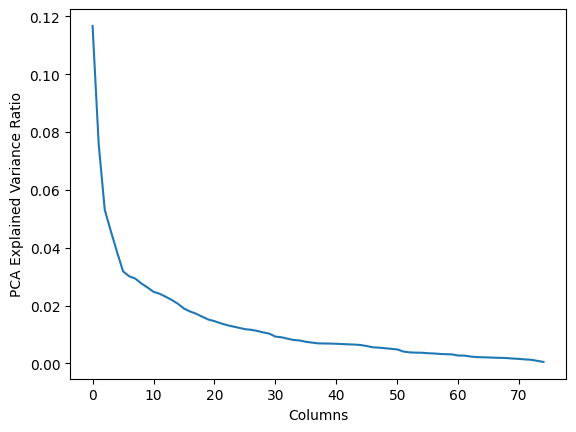

In [52]:
# Plot
plt.plot(range(X_full.shape[1]), pca.explained_variance_ratio_)
plt.xlabel("Columns")
plt.ylabel("PCA Explained Variance Ratio")

plt.show()

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.01)
print(f"There are {X_train.shape[0]} samples in the training dataset")
print(f"There are {X_test.shape[0]} samples in the testing dataset")
print(f"Each sample has {X_train.shape[1]} features")

There are 2000 samples in the training dataset
There are 198000 samples in the testing dataset
Each sample has 31 features


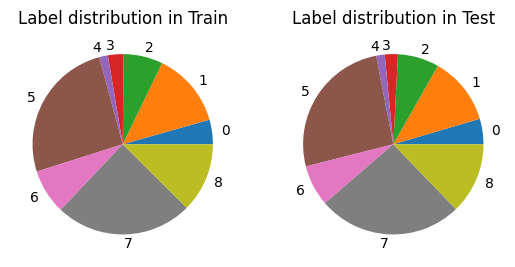

In [58]:
# show frequencies of target labels in train and test
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
ax1.pie(np.unique(y_train, return_counts=True)[1], labels=np.unique(y_train, return_counts=True)[0]);
ax1.set_title("Label distribution in Train")
ax2.pie(np.unique(y_test, return_counts=True)[1], labels=np.unique(y_test, return_counts=True)[0]);
ax2.set_title("Label distribution in Test")
plt.show()


In [59]:
scorings = ['accuracy'
            # ,'precision_macro'
            # ,'recall_macro'
            ,'f1_macro'
            ]

In [63]:
from sklearn.model_selection import ParameterGrid

trials = {label: len(list(ParameterGrid(models[label]["param"]))) for label in model_lbls}
trials

{'dt': 38, 'rf': 56}

In [80]:
results_df = pd.DataFrame(columns=["model", "scoring", "best_params", "accuracy", "precision_macro", "recall_macro", "f1_macro"])

clfs = []

In [81]:
#grid search cv
for scoring in scorings:
    for model_lbl in model_lbls:
        model = models[model_lbl]
        clf = GridSearchCV(model["estimator"], param_grid=model["param"], scoring=scoring)
        clf.fit(X_train, y_train)

        clfs.append(clf)

        y_pred = clf.predict(X_test)

        cr = classification_report(y_test, y_pred, output_dict=True)

        results_df.loc[len(results_df)] = [model["name"], scoring, clf.best_params_, cr["accuracy"], cr["macro avg"]["precision"], cr["macro avg"]["recall"], cr["macro avg"]["f1-score"]]

In [82]:
# show results
for scoring in scorings:
    display(results_df[results_df["scoring"] == scoring].sort_values(by=scoring, ascending=False).style.format(precision=3).set_caption(f"Result for scoring {scoring}"))

,model,scoring,best_params,accuracy,precision_macro,recall_macro,f1_macro
1,Random forest,accuracy,"{'class_weight': None, 'max_depth': 4, 'n_estimators': 15}",0.324,0.121,0.161,0.128
0,Decision Tree,accuracy,"{'class_weight': None, 'max_depth': 3}",0.307,0.127,0.148,0.126


,model,scoring,best_params,accuracy,precision_macro,recall_macro,f1_macro
3,Random forest,f1_macro,"{'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 25}",0.296,0.150,0.155,0.140
2,Decision Tree,f1_macro,"{'class_weight': None, 'max_depth': 7}",0.282,0.149,0.148,0.132


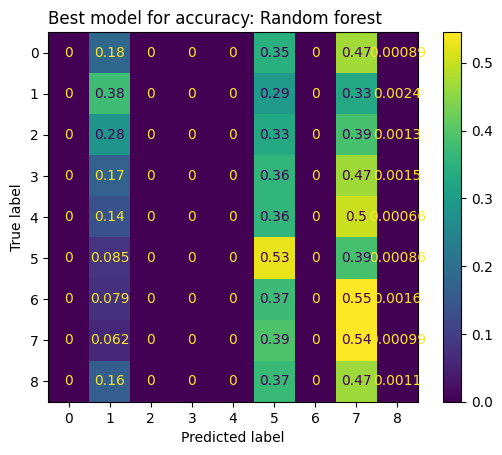

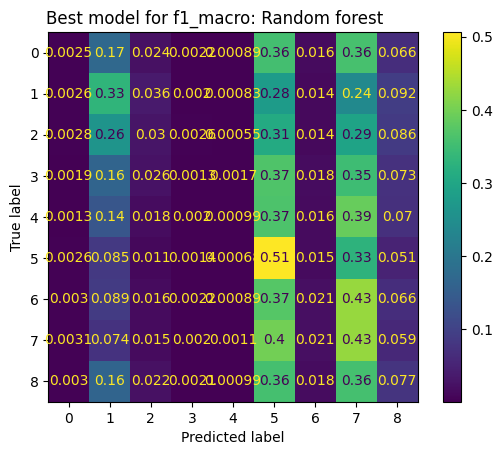

In [84]:
for scoring in scorings:
    best_row = results_df.loc[results_df["scoring"]==scoring, scoring].idxmax(axis=0)
    disp = ConfusionMatrixDisplay.from_estimator(estimator=clfs[best_row], X=X_test, y=y_test, normalize="true")

    disp.ax_.set_title(f"Best model for {scoring}: {results_df.at[best_row, "model"]}")
plt.show()